### Union Prediction for 2028 by State

Leveraging annual Bureau of Labor Statistics tables, this project forecasts each state’s 2028 union-membership rate. After decoding series IDs, imputing sparse cells, and one-hot–encoding state and demographic codes, a Gradient Boosting model reached an R² of about 0.94 and a mean-absolute error under one percentage outperforming both Linear Regression and Random Forest. Choropleth maps then translate the numbers into a clear, state-by-state outlook for labor organizers and employers.

In [1]:
# Replace with your BLS API key
api_key = '059cdf7aeb7b4eaba4b01ca1676eb0da'

In [2]:
# Import Packages
import requests
import json
import prettytable
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns

In [3]:
# Upload data | I maxed out my api attempts mutiplue days trying to figure it out, so I just downloaded everything
all_df = pd.read_csv('/Users/Malloryh5/Downloads/lu.data.0.Current', delimiter='\t')
# Print Column names
all_df.columns

Index(['series_id        ', 'year', 'period', '       value',
       'footnote_codes'],
      dtype='object')

In [4]:
#Check
all_df

,series_id,year,period,value,footnote_codes
0,LUU0202851800,1995,A01,18342,5.0
1,LUU0202851800,1996,A01,18191,5.0
2,LUU0202851800,1997,A01,18147,5.0
3,LUU0202851800,1998,A01,18401,5.0
4,LUU0202851800,1999,A01,18938,5.0
...,...,...,...,...,...
29678,LUU0264899700,2019,A01,6.4,NaN
29679,LUU0264899700,2020,A01,6.6,NaN
29680,LUU0264899700,2021,A01,6.9,NaN
29681,LUU0264899700,2022,A01,6.3,NaN


In [5]:
# Fix Column names
all_df.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

In [6]:
# new column names for all data to split series_id
series = ['survey', 'Seasonal(code)', 'stype', 'lfst_code', 'seq_code', 'fips_code']

In [7]:
# Split series_id into 6 different columns
all_df[series] = all_df['series_id'].str.extract(r'(\w{2})(\w)(\d)(\d{2})(\d{5})(\d{2})')

In [8]:
#check
all_df

,series_id,year,period,value,footnote_codes,survey,Seasonal(code),stype,lfst_code,seq_code,fips_code
0,LUU0202851800,1995,A01,18342,5.0,LU,U,0,20,28518,00
1,LUU0202851800,1996,A01,18191,5.0,LU,U,0,20,28518,00
2,LUU0202851800,1997,A01,18147,5.0,LU,U,0,20,28518,00
3,LUU0202851800,1998,A01,18401,5.0,LU,U,0,20,28518,00
4,LUU0202851800,1999,A01,18938,5.0,LU,U,0,20,28518,00
...,...,...,...,...,...,...,...,...,...,...,...
29678,LUU0264899700,2019,A01,6.4,NaN,LU,U,0,26,48997,00
29679,LUU0264899700,2020,A01,6.6,NaN,LU,U,0,26,48997,00
29680,LUU0264899700,2021,A01,6.9,NaN,LU,U,0,26,48997,00
29681,LUU0264899700,2022,A01,6.3,NaN,LU,U,0,26,48997,00


In [9]:
# Check if there is an seasonal data
if 'S' in all_df['Seasonal(code)'].values:
    print("Seasonal data")
else:
    print("No seasonal data")

No seasonal data


In [10]:
# Delete unneeded columns
# list to drop
drop_df = ['survey', 'Seasonal(code)']
# Drop
all_df = all_df.drop(columns = drop_df)

In [11]:
# Print dataframe
all_df

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code
0,LUU0202851800,1995,A01,18342,5.0,0,20,28518,00
1,LUU0202851800,1996,A01,18191,5.0,0,20,28518,00
2,LUU0202851800,1997,A01,18147,5.0,0,20,28518,00
3,LUU0202851800,1998,A01,18401,5.0,0,20,28518,00
4,LUU0202851800,1999,A01,18938,5.0,0,20,28518,00
...,...,...,...,...,...,...,...,...,...
29678,LUU0264899700,2019,A01,6.4,NaN,0,26,48997,00
29679,LUU0264899700,2020,A01,6.6,NaN,0,26,48997,00
29680,LUU0264899700,2021,A01,6.9,NaN,0,26,48997,00
29681,LUU0264899700,2022,A01,6.3,NaN,0,26,48997,00


In [12]:
# make value numeric
all_df['value'] = pd.to_numeric(all_df['value'], errors='coerce')

In [13]:
# Convert 'year' column to integer if it's not already
all_df['year'] = all_df['year'].astype(int)
# Convert 'value' column to float if it's not already
all_df['value'] = all_df['value'].astype(float)

In [14]:
# Keys
df_seasonal = pd.read_csv('/Users/Malloryh5/Downloads/lu.seasonal', delimiter='\t')
dfs_lfst = pd.read_csv('/Users/Malloryh5/Downloads/lu.lfst.txt', delimiter='\t')
dft_seq = pd.read_csv('/Users/Malloryh5/Downloads/lu.series', delimiter='\t')
dfs_fips = pd.read_csv('/Users/Malloryh5/Downloads/lu.fips', delimiter='\t')

# Keys for datasets
tdata_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.tdata', delimiter='\t')
pcts_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.pcts', delimiter='\t')
earn_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.earn', delimiter='\t')
class_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.class', delimiter='\t')
unin_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.unin', delimiter='\t')
indy_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.indy.txt', delimiter='\t')
occupation_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.occupation', delimiter='\t')
education_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.education', delimiter='\t')
ages_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.ages', delimiter='\t')
race_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.race', delimiter='\t')
orig_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.orig', delimiter='\t')
sexs_code = pd.read_csv('/Users/Malloryh5/Downloads/lu.sexs', delimiter='\t')
seasonal = pd.read_csv('/Users/Malloryh5/Downloads/lu.seasonal', delimiter='\t')
footnote_codes = pd.read_csv('/Users/Malloryh5/Downloads/lu.footnote', delimiter='\t')

In [15]:
# review column names
dft_seq.columns

Index(['series_id        ', 'lfst_code', 'fips_code', 'series_title',
       'tdata_code', 'pcts_code', 'earn_code', 'class_code', 'unin_code',
       'indy_code', 'occupation_code', 'education_code', 'ages_code',
       'race_code', 'orig_code', 'sexs_code', 'seasonal', 'footnote_codes',
       'begin_year', 'begin_period', 'end_year', 'end_period'],
      dtype='object')

In [16]:
#Strip and remove all white space
dft_seq = dft_seq.rename(columns=lambda x: x.strip())
dft_seq['series_id'] = dft_seq['series_id'].str.strip()
dft_seq['series_title'] = dft_seq['series_title'].str.strip()

Are people who are part of a union paid more than non-union individuals or people represented by a union?

In [17]:
# Save just in case. Do not need to look at goverment, but keep in case, I change my mind
total_earnings = dft_seq[
    dft_seq['series_title'].str.contains('weekly earnings', case=False, na=False) &
    (dft_seq['occupation_code'] == 0) &
    (dft_seq['indy_code'] == 0) &
    (dft_seq['ages_code'] == 0) &
    (dft_seq['sexs_code'] == 0) &
    (dft_seq['race_code'] == 0) &
    (dft_seq['orig_code'] == 0) &
    (dft_seq['class_code'] == 16)
]
# Private sector
need_data_earnings = dft_seq[
    dft_seq['series_title'].str.contains('weekly earnings', case=False, na=False) &
    (dft_seq['occupation_code'] == 0) &
    (dft_seq['indy_code'] == 0) &
    (dft_seq['ages_code'] == 0) &
    (dft_seq['sexs_code'] == 0) &
    (dft_seq['race_code'] == 0) &
    (dft_seq['orig_code'] == 0) &
    (dft_seq['class_code'] == 17)
]

In [18]:
# Remove white shace in column header
need_data_earnings.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

/var/folders/q9/wrynvqzj0dgb0yksnkbr0sj40000gn/T/ipykernel_9305/940145784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_data_earnings.rename(columns=lambda x: x.replace(' ', ''), inplace=True)


In [19]:
# List of series that needs to be pulled
series_id_earning = need_data_earnings['series_id'].unique().tolist()
# List of year that needs to be pulled
year = list(range(2014,2024))

In [20]:
# Remove spaces
series_id_earning = [x.replace(' ', '') for x in series_id_earning]

In [21]:
# Strip white space
all_df['series_id'] = all_df['series_id'].str.strip()

In [22]:
# Pull data that is only in series list
df_earnings = all_df[all_df['series_id'].isin(series_id_earning)]
# Pull data that is only in year list
df_earnings = (df_earnings[df_earnings['year'].isin(year)])

In [23]:
#Check
df_earnings

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code
21993,LUU0253191200,2014,A01,763.0,NaN,0,25,31912,00
21994,LUU0253191200,2015,A01,776.0,NaN,0,25,31912,00
21995,LUU0253191200,2016,A01,801.0,NaN,0,25,31912,00
21996,LUU0253191200,2017,A01,829.0,NaN,0,25,31912,00
21997,LUU0253191200,2018,A01,861.0,NaN,0,25,31912,00
21998,LUU0253191200,2019,A01,893.0,NaN,0,25,31912,00
21999,LUU0253191200,2020,A01,959.0,NaN,0,25,31912,00
22000,LUU0253191200,2021,A01,973.0,NaN,0,25,31912,00
22001,LUU0253191200,2022,A01,1026.0,NaN,0,25,31912,00
22002,LUU0253191200,2023,A01,1087.0,NaN,0,25,31912,00


In [24]:
# Create a mapping
series_title_map = dict(zip(dft_seq['series_id'], dft_seq['series_title']))

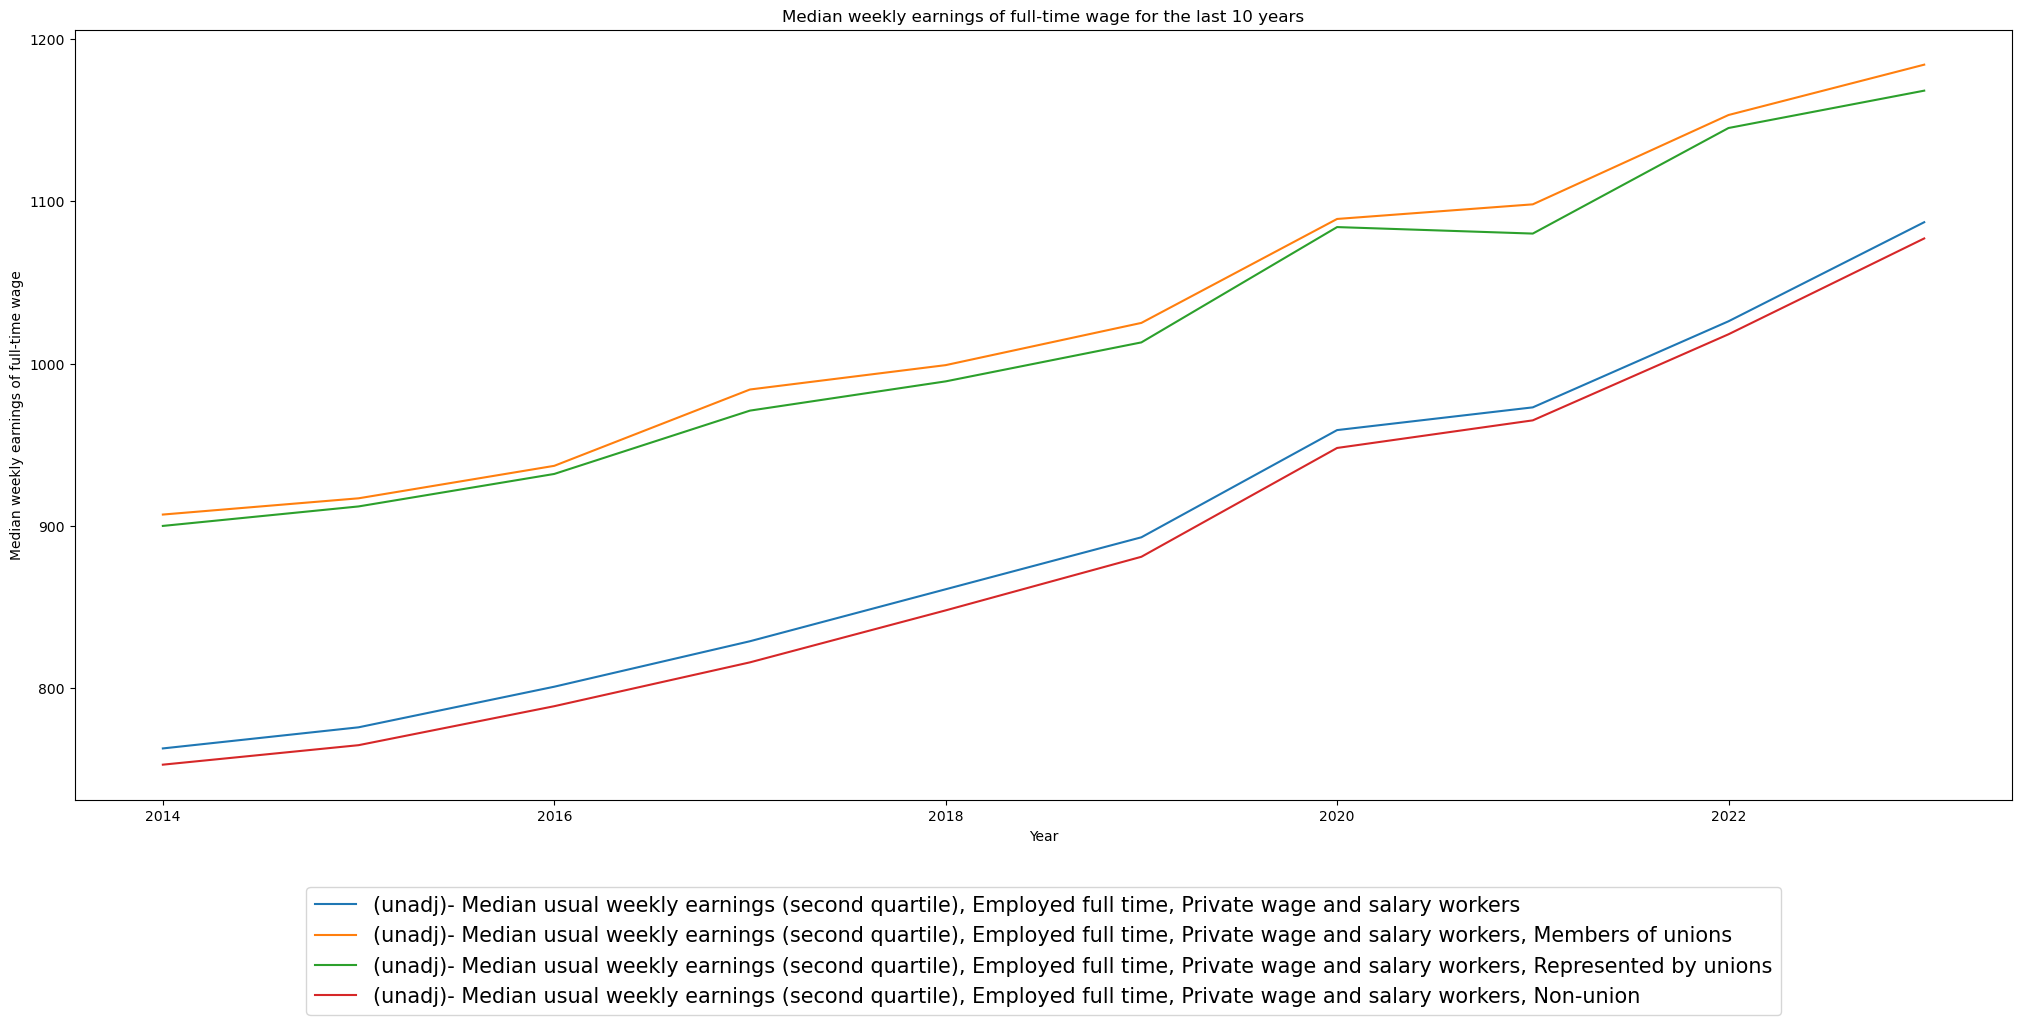

In [25]:
# Make table

#Size of graph
plt.figure(figsize=(25,10))

#For loop to make a line for every union option
for series in df_earnings['series_id'].unique():
    # for every series make a subset
    subset = df_earnings[df_earnings['series_id'] == series]
    # Use map for legend
    series_ledger = series_title_map.get(series, series) 
    # plot line graph and group by label
    plt.plot(subset['year'], subset['value'], label=series_ledger)
# x-label
plt.xlabel('Year')
#y-label
plt.ylabel('Median weekly earnings of full-time wage')
#title
plt.title('Median weekly earnings of full-time wage for the last 10 years')
#legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=15)
#show
plt.show()

In [26]:
# Make int
all_df['fips_code'] = all_df['fips_code'].astype(int)

States that are more likely to be part of a union?

In [27]:
# List of wanted items
union_by_state_prisec = dft_seq[
    (dft_seq['sexs_code'] == 0) &
    (dft_seq['indy_code'] == 0) &
    (dft_seq['ages_code'] == 0) &
    (dft_seq['series_title'].str.contains('Percent of employed, ', case=False, na=False, regex=False)) &
    (dft_seq['race_code'] == 0) &
    (dft_seq['orig_code'] == 0) &
    (dft_seq['fips_code'].isin(range(1, 57)))
]

In [28]:
#Print to check
union_by_state_prisec

,series_id,lfst_code,fips_code,series_title,tdata_code,pcts_code,earn_code,class_code,unin_code,indy_code,...,ages_code,race_code,orig_code,sexs_code,seasonal,footnote_codes,begin_year,begin_period,end_year,end_period
458,LUU0204899601,20,1,"(unadj)- Percent of employed, Members of union...",1,5,0,16,1,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
459,LUU0204899602,20,2,"(unadj)- Percent of employed, Members of union...",1,5,0,16,1,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
460,LUU0204899604,20,4,"(unadj)- Percent of employed, Members of union...",1,5,0,16,1,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
461,LUU0204899605,20,5,"(unadj)- Percent of employed, Members of union...",1,5,0,16,1,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
462,LUU0204899606,20,6,"(unadj)- Percent of employed, Members of union...",1,5,0,16,1,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,LUU0204899751,20,51,"(unadj)- Percent of employed, Represented by u...",1,5,0,16,2,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
557,LUU0204899753,20,53,"(unadj)- Percent of employed, Represented by u...",1,5,0,16,2,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
558,LUU0204899754,20,54,"(unadj)- Percent of employed, Represented by u...",1,5,0,16,2,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01
559,LUU0204899755,20,55,"(unadj)- Percent of employed, Represented by u...",1,5,0,16,2,0,...,0,0,0,0,U,NaN,2000,A01,2023,A01


In [29]:
# List of series that needs to be pulled
state_unique_id = union_by_state_prisec['series_id'].unique()

# List of year that needs to be pulled
year_state = [2013, 2018, 2023]

In [30]:
# Drop Union code 3 and 0
unin_code_28 = unin_code.drop(index=[0,3]).copy()

In [31]:
unin_code_28

,unin_code,unin_text
1,1,Members of unions
2,2,Represented by unions


In [32]:
# Pull data that is only in series list
state_union = all_df[
    all_df['series_id'].isin(state_unique_id) &
    all_df['year'].isin(year_state)
]

In [33]:
# Check if it was donw right
state_union['fips_code'] = state_union['fips_code'].astype(int)

/var/folders/q9/wrynvqzj0dgb0yksnkbr0sj40000gn/T/ipykernel_9305/1963364285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_union['fips_code'] = state_union['fips_code'].astype(int)


In [34]:
# make dic of states
state_name = dict(zip(dfs_fips['fips_code'], dfs_fips['fips_text']))

In [35]:
# Map file
us_map = gpd.read_file('/Users/Malloryh5/Downloads/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')

In [36]:
# map names
state_union['state_name'] = state_union['fips_code'].map(state_name)

/var/folders/q9/wrynvqzj0dgb0yksnkbr0sj40000gn/T/ipykernel_9305/3537762183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_union['state_name'] = state_union['fips_code'].map(state_name)


In [37]:
# Add union code to list of data
merged_df = state_union.merge(union_by_state_prisec[['series_id', 'unin_code']], on='series_id', how='left')
# Check table
merged_df

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code,state_name,unin_code
0,LUU0204899601,2013,A01,10.7,NaN,0,20,48996,1,Alabama,1
1,LUU0204899601,2018,A01,9.2,NaN,0,20,48996,1,Alabama,1
2,LUU0204899601,2023,A01,7.5,NaN,0,20,48996,1,Alabama,1
3,LUU0204899602,2013,A01,23.1,NaN,0,20,48996,2,Alaska,1
4,LUU0204899602,2018,A01,18.5,NaN,0,20,48996,2,Alaska,1
...,...,...,...,...,...,...,...,...,...,...,...
301,LUU0204899755,2018,A01,8.6,NaN,0,20,48997,55,Wisconsin,2
302,LUU0204899755,2023,A01,8.4,NaN,0,20,48997,55,Wisconsin,2
303,LUU0204899756,2013,A01,6.4,NaN,0,20,48997,56,Wyoming,2
304,LUU0204899756,2018,A01,7.7,NaN,0,20,48997,56,Wyoming,2


In [38]:
# Make a legder code
unicode_titles_map = dict(zip(unin_code['unin_code'], unin_code['unin_text']))

In [39]:
# Merge us_map with state_union_merge based on 'fips' and 'fips_code'
us_states_merged = pd.merge(us_map, merged_df, left_on='NAME', right_on='state_name', how='left')

In [40]:
#year
year = 2023
# union codes
unique_codes = merged_df['unin_code'].unique()

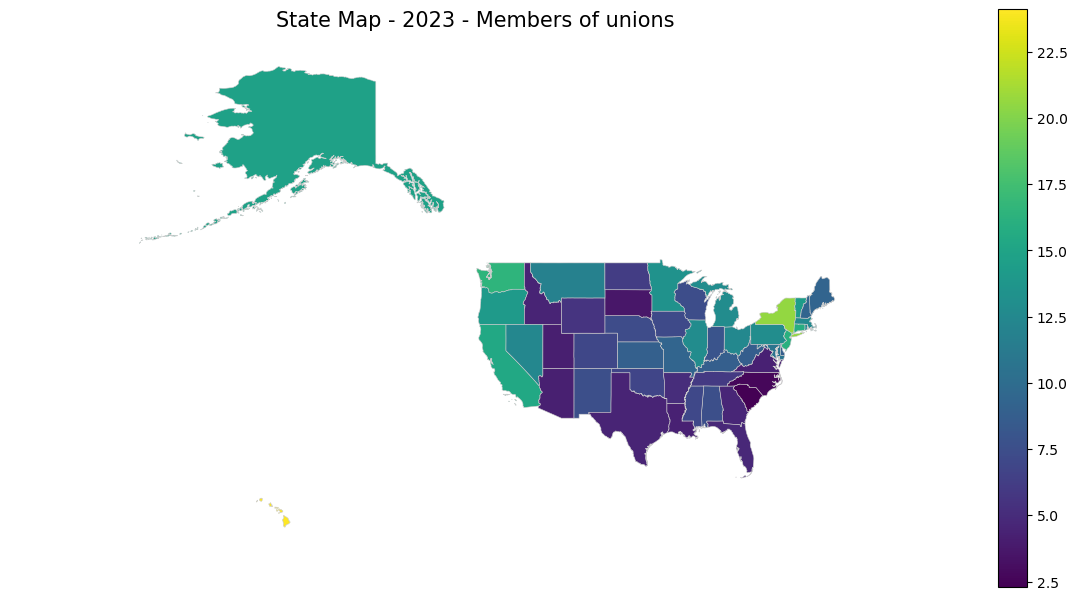

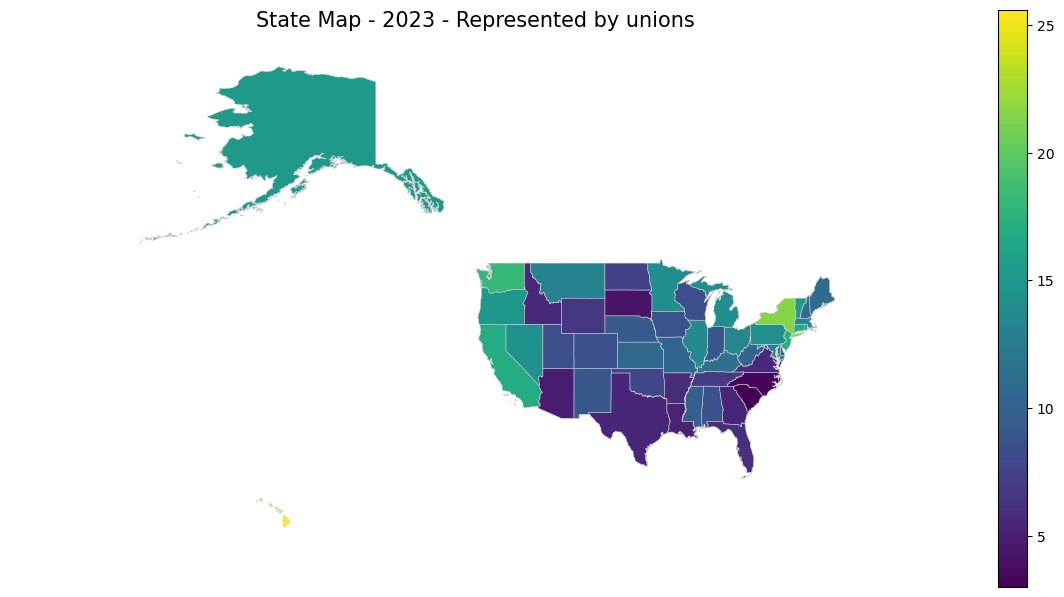

In [41]:
# for loop to plot people who are union and represented by a union on different maps
for code in unique_codes:
    # Filter the data for the current year and unique code
    year_data = us_states_merged[(us_states_merged['year'] == year) & (us_states_merged['unin_code'] == code)]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    year_data.plot(column='value', cmap='viridis', linewidth=0.4, edgecolor='0.8', legend=True, legend_kwds={'shrink': 0.5}, ax=ax)
    
    # Set the title
    ax.set_title(f'State Map - {year} - {unicode_titles_map.get(code, "Unknown Code")}', fontsize=15)
    
    # Set axis limits
    ax.set_xlim(-200, -50)
    ax.set_ylim(15, 75)
    
    # Remove axis
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    
    # Show the plot
    plt.show()


Demographics that is more likely to be part of a union?

In [42]:
# List of wanted items 
dem_df = dft_seq[
    (~dft_seq['series_title'].str.contains('Employed wage and salary', case=False, na=False)) &
    (dft_seq['indy_code'] == 0) &
    (dft_seq['lfst_code'] == 20) &
    (dft_seq['earn_code'] == 0) &
    (dft_seq['fips_code'] == 0) &
    (dft_seq['tdata_code'] == 1) &
    (dft_seq['occupation_code'] == 0)
]


In [43]:
# Check problem
dem_df.columns

Index(['series_id', 'lfst_code', 'fips_code', 'series_title', 'tdata_code',
       'pcts_code', 'earn_code', 'class_code', 'unin_code', 'indy_code',
       'occupation_code', 'education_code', 'ages_code', 'race_code',
       'orig_code', 'sexs_code', 'seasonal', 'footnote_codes', 'begin_year',
       'begin_period', 'end_year', 'end_period'],
      dtype='object')

In [44]:
# Remove white space
dem_df = dem_df.rename(columns=lambda x: x.replace(' ', ''))

In [45]:
# List of series that needs to be pulled
dem_unique_id = dem_df['series_id'].unique()

# List of year that needs to be pulled
year = list(range(2014,2024))

In [46]:
#Check list
dem_unique_id

array(['LUU0204899600', 'LUU0204899700', 'LUU0204899800', 'LUU0204899900',
       'LUU0204900000', 'LUU0204900100', 'LUU0204900200', 'LUU0204900300',
       'LUU0204900400', 'LUU0204900500', 'LUU0204900600', 'LUU0204900700',
       'LUU0204900800', 'LUU0204900900', 'LUU0204901000', 'LUU0204901100',
       'LUU0204901200', 'LUU0204901300', 'LUU0204901400', 'LUU0204901500',
       'LUU0204901600', 'LUU0204901700', 'LUU0204901800', 'LUU0204901900',
       'LUU0204902000', 'LUU0204902100', 'LUU0204902200', 'LUU0204902300',
       'LUU0204902400', 'LUU0204902500', 'LUU0204902600', 'LUU0204902700',
       'LUU0204902800', 'LUU0204902900', 'LUU0204903000', 'LUU0204903100',
       'LUU0204903200', 'LUU0204903300', 'LUU0204903400', 'LUU0204903500',
       'LUU0204903600', 'LUU0204903700', 'LUU0204903800', 'LUU0204903900',
       'LUU0204904000', 'LUU0204904100', 'LUU0204904200', 'LUU0204904300',
       'LUU0204904400', 'LUU0204904500', 'LUU0204904600', 'LUU0204904700',
       'LUU0204904800', '

In [47]:
# Pull data that is only in series list
dem_union = all_df[
    all_df['series_id'].isin(dem_unique_id) &
    all_df['year'].isin(year)
]

In [48]:
# Check table
dem_union

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code
11052,LUU0204899600,2014,A01,11.1,NaN,0,20,48996,0
11053,LUU0204899600,2015,A01,11.1,NaN,0,20,48996,0
11054,LUU0204899600,2016,A01,10.7,NaN,0,20,48996,0
11055,LUU0204899600,2017,A01,10.7,NaN,0,20,48996,0
11056,LUU0204899600,2018,A01,10.5,NaN,0,20,48996,0
...,...,...,...,...,...,...,...,...,...
18950,LUU0204924400,2019,A01,43.0,NaN,0,20,49244,0
18951,LUU0204924400,2020,A01,45.1,NaN,0,20,49244,0
18952,LUU0204924400,2021,A01,43.9,NaN,0,20,49244,0
18953,LUU0204924400,2022,A01,42.7,NaN,0,20,49244,0


In [49]:
# replace codes orig
orig_code['orig_code'].replace({0: 5, 1: 6}, inplace=True)
# replace code orig
dem_df['orig_code'].replace({0: 5, 1: 6}, inplace=True)

# replace codes race
race_code['race_code'].replace({0: 7, 1: 9}, inplace=True)
# replace code orig
dem_df['race_code'].replace({0: 7, 1: 9}, inplace=True)

# replace codes age
ages_code['ages_code'].replace({0: 8}, inplace=True)
# replace code age
dem_df['ages_code'].replace({0: 8}, inplace=True)

In [50]:
# items to remove
values_to_replace = {'ages_code': 8, 'race_code': 7, 'sexs_code': 0}

# For loop to remove values
for column, value in values_to_replace.items():
    # replace values and put nan for no values
    dem_df[column] = dem_df[column].replace(value, np.nan)

In [51]:
#dic for map
ages_code_map = dict(zip(ages_code['ages_code'],ages_code['ages_text']))
race_code_map = dict(zip(race_code['race_code'],race_code['race_text']))
orig_code_map = dict(zip(orig_code['orig_code'], orig_code['orig_text']))
sexs_code_map = dict(zip(sexs_code['sexs_code'], sexs_code['sexs_text']))

#Combine dict to make key
one_dict = {}
one_dict.update(orig_code_map)
one_dict.update(ages_code_map)
one_dict.update(race_code_map)
one_dict.update(sexs_code_map)

In [52]:
# merge certian columns
dem_union = dem_union.merge(dem_df[['series_id', 'ages_code','race_code','orig_code','sexs_code']], on='series_id', how='left')

In [53]:
#Review
one_dict

{5: 'All Origins',
 6: 'Hispanic or Latino',
 8: '16 years and over',
 10: '16 to 24 years',
 28: '25 years and over',
 31: '25 to 34 years',
 38: '35 to 44 years',
 42: '45 to 54 years',
 49: '55 to 64 years',
 65: '65 years and over',
 7: 'All Races',
 9: 'White',
 3: 'Black or African American',
 4: 'Asian',
 0: 'Both Sexes',
 1: 'Men',
 2: 'Women'}

In [54]:
# Check table
dem_union

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code,ages_code,race_code,orig_code,sexs_code
0,LUU0204899600,2014,A01,11.1,NaN,0,20,48996,0,NaN,NaN,5,NaN
1,LUU0204899600,2015,A01,11.1,NaN,0,20,48996,0,NaN,NaN,5,NaN
2,LUU0204899600,2016,A01,10.7,NaN,0,20,48996,0,NaN,NaN,5,NaN
3,LUU0204899600,2017,A01,10.7,NaN,0,20,48996,0,NaN,NaN,5,NaN
4,LUU0204899600,2018,A01,10.5,NaN,0,20,48996,0,NaN,NaN,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,LUU0204924400,2019,A01,43.0,NaN,0,20,49244,0,NaN,NaN,5,NaN
816,LUU0204924400,2020,A01,45.1,NaN,0,20,49244,0,NaN,NaN,5,NaN
817,LUU0204924400,2021,A01,43.9,NaN,0,20,49244,0,NaN,NaN,5,NaN
818,LUU0204924400,2022,A01,42.7,NaN,0,20,49244,0,NaN,NaN,5,NaN


In [55]:
# list 
list_dem = ['ages_code','race_code','orig_code','sexs_code']

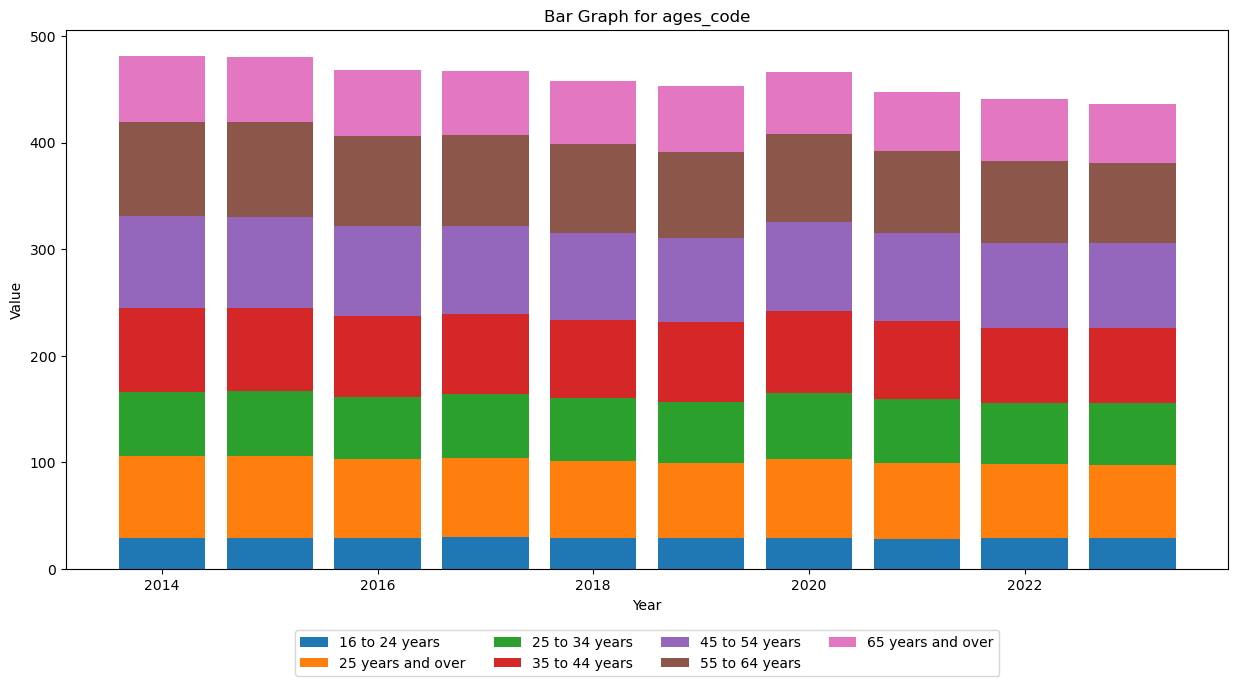

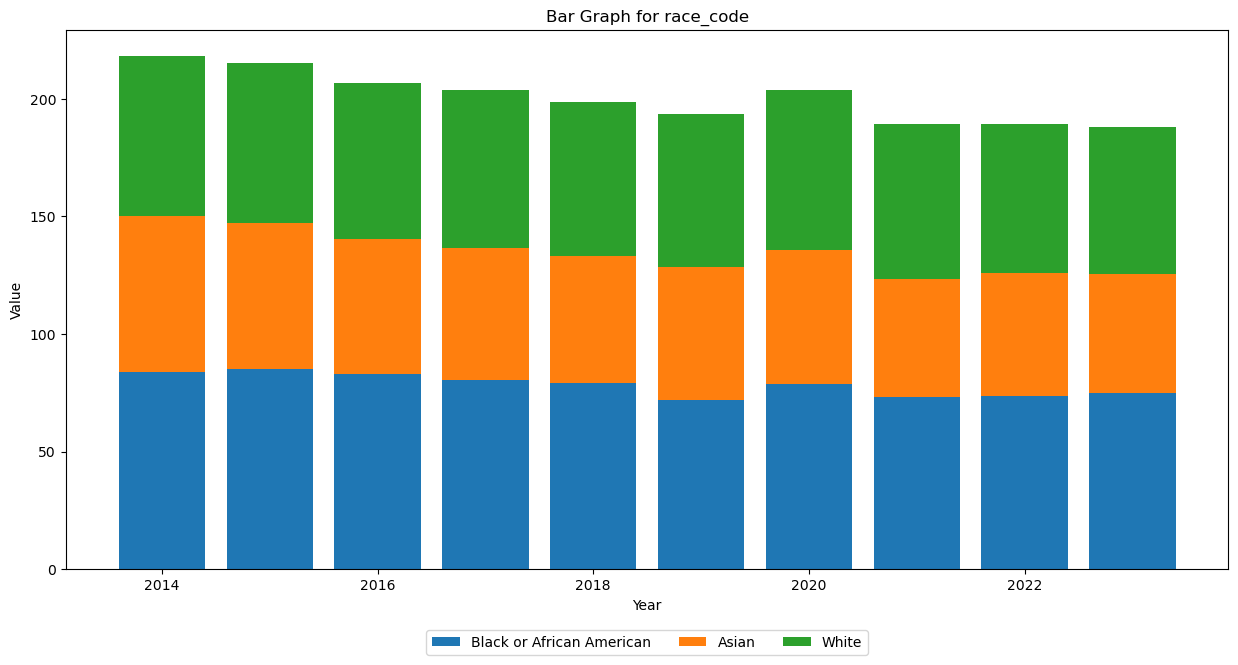

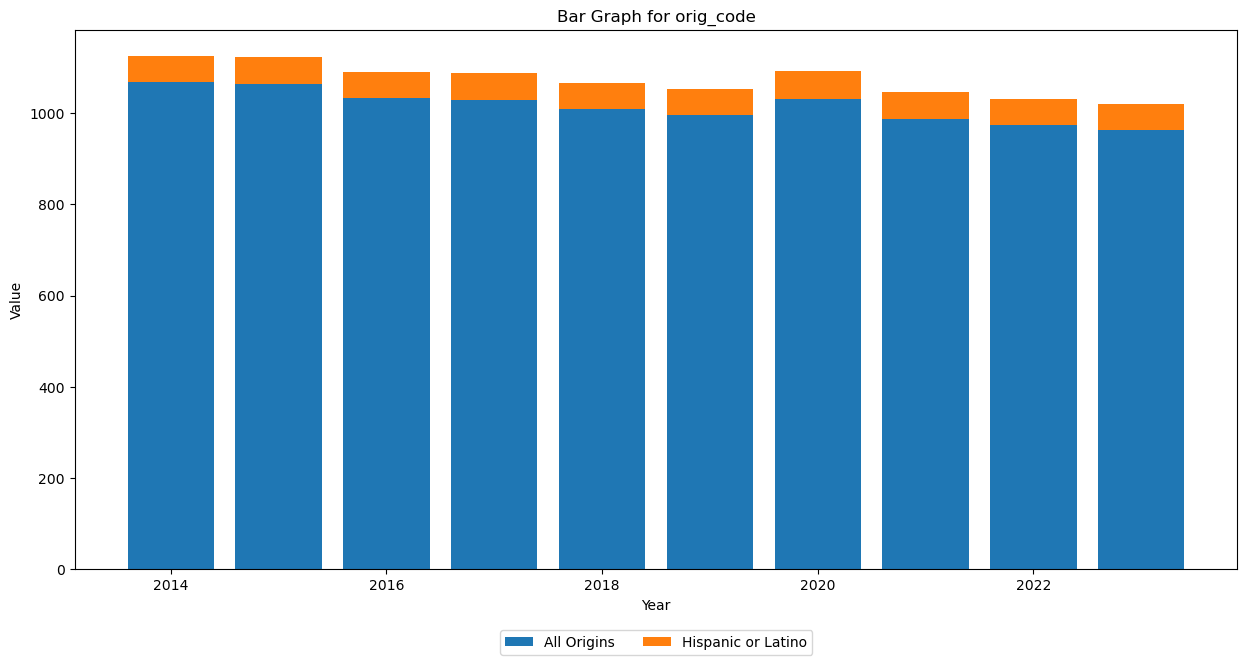

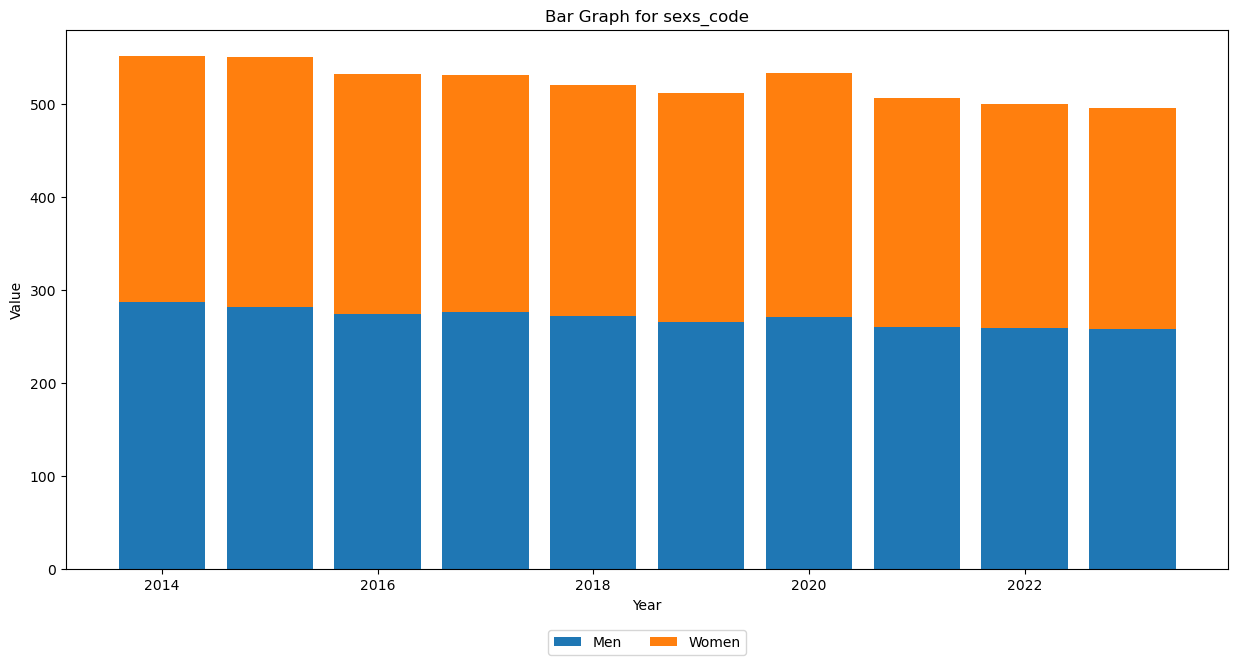

In [56]:
#For loop for ever dem. in list
for dem in list_dem:
    #Figure size
    plt.figure(figsize=(15, 7))
    # Pivot the data
    pivot_df = dem_union.pivot_table(index='year', columns=dem, values='value', aggfunc='sum').fillna(0)
    
    # Iterate over each unique value in the demographic column to create stacked bars
    bottom_values = [0] * len(pivot_df.index)
   # For loop for each item on list_dem
    for category in pivot_df.columns:
        # Make bar plot
        plt.bar(pivot_df.index, pivot_df[category], bottom=bottom_values, label=one_dict.get(category, category))
        # Stack the values
        bottom_values += pivot_df[category]
    
    # x-label
    plt.xlabel('Year')
    # y-label
    plt.ylabel('Value')
    #title
    plt.title(f'Bar Graph for {dem}')
    
    # Add legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=10, ncol=4)
    
    # Show the plot
    plt.show()

Is union membership decreasing or increasing by industry?

In [57]:
# look at values to find what is needed
indy_code['indy_code'].unique()

array([   0,  168,  368,  369,  569,  770, 1068, 2467, 2468, 4067, 4068,
       4669, 6068, 6069, 6468, 6469, 6569, 6670, 6679, 6769, 6867, 6868,
       6869, 6990, 7069, 7268, 7269, 7569, 7858, 7859, 7968, 8558, 8559,
       8658, 8659, 8679, 8767, 8768, 9290])

In [58]:
# indy list
indy_df = dft_seq[
    (dft_seq['ages_code'] == 0) &
    (dft_seq['sexs_code'] == 0) &
    (dft_seq['race_code'] == 0) &
    (dft_seq['fips_code'] == 0) &
    (dft_seq['unin_code'] == 1) &
    (dft_seq['earn_code'] == 0) &
    (dft_seq['pcts_code'] == 0) &
    (dft_seq['indy_code'].isin([168, 369, 569, 770, 1068, 2468, 4068,
       4669, 6069, 6469, 6569, 6670, 6679, 6769, 6868,
       6869, 6990, 7069, 7269, 7569, 7859, 7968, 8559, 8659, 8679, 8768, 9290]))
    
]

In [59]:
#Remove white space
indy_df.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

/var/folders/q9/wrynvqzj0dgb0yksnkbr0sj40000gn/T/ipykernel_9305/2806861879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_df.rename(columns=lambda x: x.replace(' ', ''), inplace=True)


In [60]:
# List of series that needs to be pulled
series_id_indy = indy_df['series_id'].unique().tolist()
# Remove spaces
series_id_indy = [x.replace(' ', '') for x in series_id_indy]
# List of year that needs to be pulled
year = list(range(2014,2024))

In [61]:
# look at list
series_id_indy

['LUU0204794500',
 'LUU0204794700',
 'LUU0204794800',
 'LUU0204795000',
 'LUU0204795300',
 'LUU0204795400',
 'LUU0204795600',
 'LUU0204795700',
 'LUU0204795900',
 'LUU0204796000',
 'LUU0204796100',
 'LUU0204796300',
 'LUU0204796700',
 'LUU0204796800',
 'LUU0204796900',
 'LUU0204797000',
 'LUU0204797200',
 'LUU0204797300',
 'LUU0204797500',
 'LUU0204797600',
 'LUU0204797800',
 'LUU0204798000',
 'LUU0204798300',
 'LUU0204798400',
 'LUU0204921300',
 'LUU0204933400']

In [62]:
# Pull data that is only in series list
df_indy = all_df[all_df['series_id'].isin(series_id_indy) & all_df['year'].isin(year)]

In [63]:

df_indy = df_indy.merge(indy_df[['series_id', 'indy_code', 'unin_code']], on='series_id', how='left', suffixes=('', '_indy'))

In [64]:
#check
df_indy.columns

Index(['series_id', 'year', 'period', 'value', 'footnote_codes', 'stype',
       'lfst_code', 'seq_code', 'fips_code', 'indy_code', 'unin_code'],
      dtype='object')

In [65]:
# Create a mapping
indy_map = dict(zip(indy_code['indy_code'], indy_code['indy_text']))

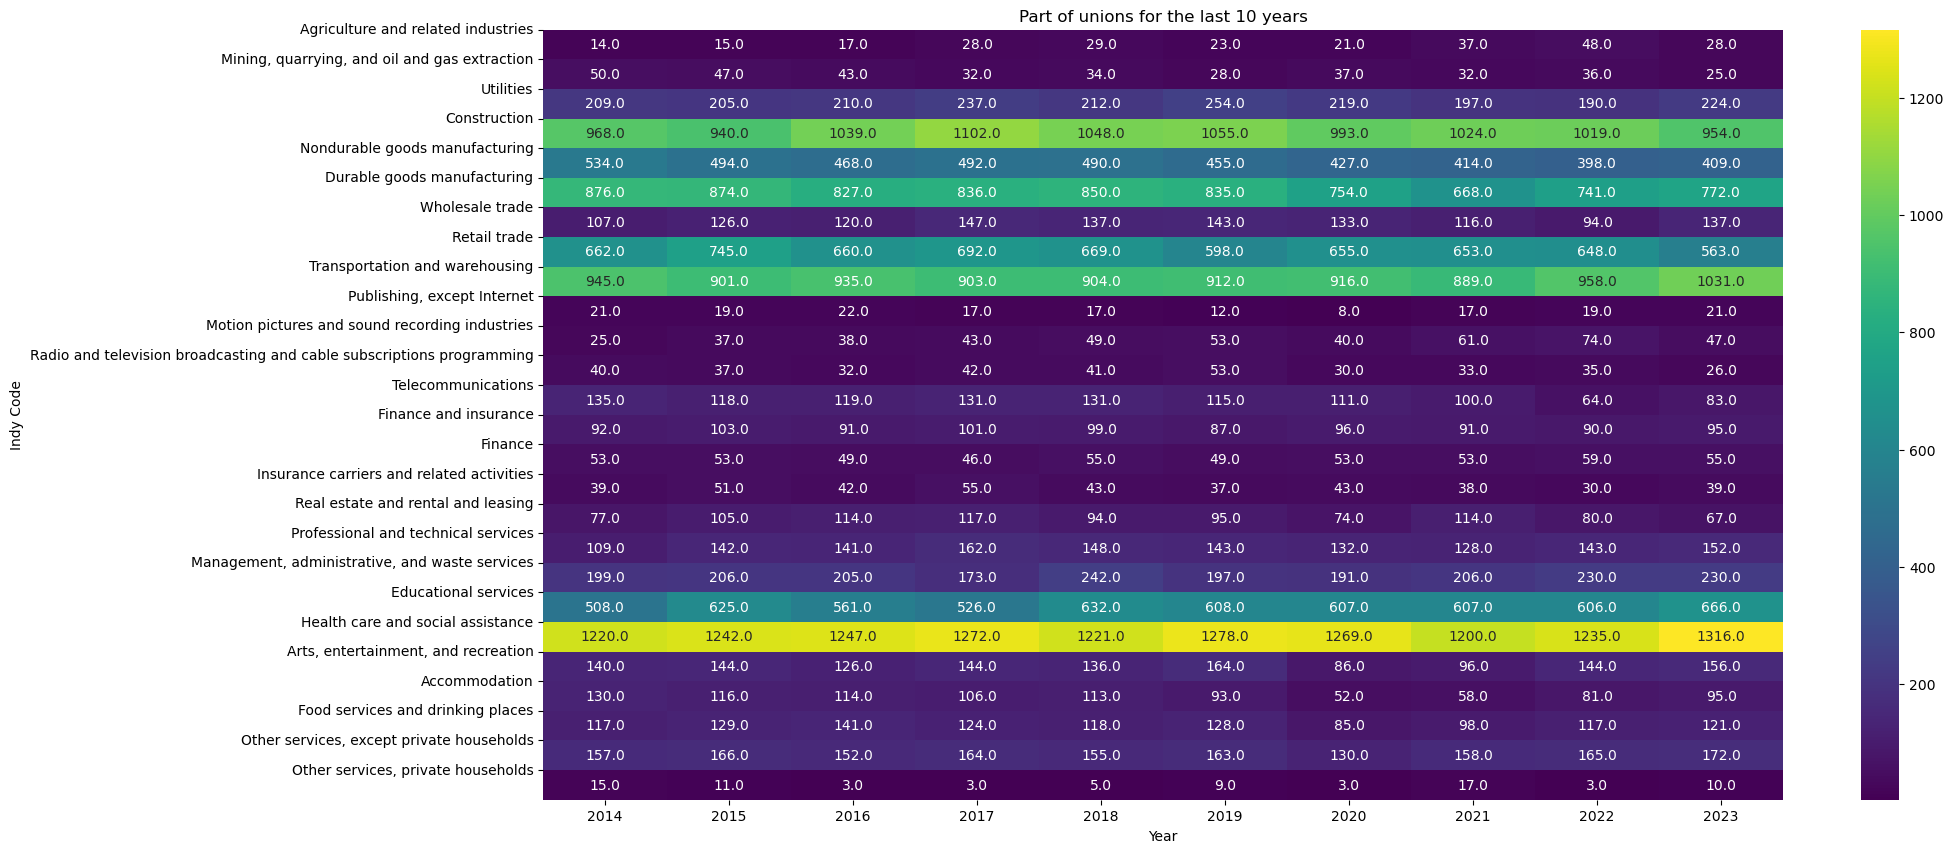

In [66]:
# Groupby indy and year, calculate mean value
grouped_df = df_indy.groupby(['indy_code', 'year'])['value'].mean().reset_index()

# Pivot table for heatmap
pivot_table = grouped_df.pivot(index='indy_code', columns='year', values='value')

#Figure size
plt.figure(figsize=(20, 10))
# heatmap using sns
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='viridis', cbar=True)

#x-label
plt.xlabel('Year')
#y-label
plt.ylabel('Indy Code')
#Title
plt.title('Part of unions for the last 10 years')

# Indy y-axis labels
plt.yticks(ticks=range(len(pivot_table.index)), labels=[indy_map.get(indy_code, indy_code) for indy_code in pivot_table.index])

# Display plot
plt.show()


The first plot shows the Median weekly earnings of full-time wages for the last ten years. Union members have been paid about $100 - 150 more than. However, the pay gap is slowly decreasing. The second graph shows that unions are more likely out west and north but less likely in the south. The third graph looks at the demographics of people in a union. There has not been much change in demographics over the last 10 years, but there was an increase in 2020. This could have to do with the fact that many people were overworking during this time, so they were more unhappy. Hispanics are less likely to be a part of a union. Younger individuals are less likely to be a part of unions. The fourth graph is a heat graph that shows the number of people in unions by industry. The top industries with the highest union numbers are:
Health care and social assistance.
Construction.
Durable goods manufacturing, transportation, and warehousing. 

- Data from bls.gov

Based on only union membership and individuals represented by unions,what would be the best place to open a new location in three years?

#### Remove any data that doe not meet publication criteria

In [67]:
# function to remove data that has footnote_code 7
def meets_criteria(data):
    return (data[data['footnote_codes'] != 7])

In [68]:
# Drop all rows from data that does not need criteria
df_earnings = meets_criteria(df_earnings)
merged_df = meets_criteria(merged_df)
dem_union = meets_criteria(dem_union)
df_indy = meets_criteria(df_indy)

In [69]:
df_earnings.head()

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code
21993,LUU0253191200,2014,A01,763.0,NaN,0,25,31912,00
21994,LUU0253191200,2015,A01,776.0,NaN,0,25,31912,00
21995,LUU0253191200,2016,A01,801.0,NaN,0,25,31912,00
21996,LUU0253191200,2017,A01,829.0,NaN,0,25,31912,00
21997,LUU0253191200,2018,A01,861.0,NaN,0,25,31912,00


In [70]:
df_indy.head()

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code,indy_code,unin_code
0,LUU0204794500,2014,A01,14.0,NaN,0,20,47945,0,168,1
1,LUU0204794500,2015,A01,15.0,NaN,0,20,47945,0,168,1
2,LUU0204794500,2016,A01,17.0,NaN,0,20,47945,0,168,1
3,LUU0204794500,2017,A01,28.0,NaN,0,20,47945,0,168,1
4,LUU0204794500,2018,A01,29.0,NaN,0,20,47945,0,168,1


In [71]:
dem_union.head()

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code,ages_code,race_code,orig_code,sexs_code
0,LUU0204899600,2014,A01,11.1,NaN,0,20,48996,0,NaN,NaN,5,NaN
1,LUU0204899600,2015,A01,11.1,NaN,0,20,48996,0,NaN,NaN,5,NaN
2,LUU0204899600,2016,A01,10.7,NaN,0,20,48996,0,NaN,NaN,5,NaN
3,LUU0204899600,2017,A01,10.7,NaN,0,20,48996,0,NaN,NaN,5,NaN
4,LUU0204899600,2018,A01,10.5,NaN,0,20,48996,0,NaN,NaN,5,NaN


In [72]:
merged_df.head()

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code,state_name,unin_code
0,LUU0204899601,2013,A01,10.7,NaN,0,20,48996,1,Alabama,1
1,LUU0204899601,2018,A01,9.2,NaN,0,20,48996,1,Alabama,1
2,LUU0204899601,2023,A01,7.5,NaN,0,20,48996,1,Alabama,1
3,LUU0204899602,2013,A01,23.1,NaN,0,20,48996,2,Alaska,1
4,LUU0204899602,2018,A01,18.5,NaN,0,20,48996,2,Alaska,1


In [73]:
df_earnings.head()

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code
21993,LUU0253191200,2014,A01,763.0,NaN,0,25,31912,00
21994,LUU0253191200,2015,A01,776.0,NaN,0,25,31912,00
21995,LUU0253191200,2016,A01,801.0,NaN,0,25,31912,00
21996,LUU0253191200,2017,A01,829.0,NaN,0,25,31912,00
21997,LUU0253191200,2018,A01,861.0,NaN,0,25,31912,00


Code 7 in the footnote_codes column means the data does not meet the criteria to be published. Although the criteria is unknown, I decided that it would be best to remove it.

#### Combine datasets

I will combine all the data to simplify my assessment.

In [74]:
# Combine te datasets
data = pd.concat([df_earnings,merged_df,dem_union, df_indy], ignore_index=True)

In [75]:
data

,series_id,year,period,value,footnote_codes,stype,lfst_code,seq_code,fips_code,state_name,unin_code,ages_code,race_code,orig_code,sexs_code,indy_code
0,LUU0253191200,2014,A01,763.0,NaN,0,25,31912,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUU0253191200,2015,A01,776.0,NaN,0,25,31912,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LUU0253191200,2016,A01,801.0,NaN,0,25,31912,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUU0253191200,2017,A01,829.0,NaN,0,25,31912,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUU0253191200,2018,A01,861.0,NaN,0,25,31912,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,LUU0204933400,2019,A01,128.0,NaN,0,20,49334,0,NaN,1.0,NaN,NaN,NaN,NaN,8679.0
1422,LUU0204933400,2020,A01,85.0,NaN,0,20,49334,0,NaN,1.0,NaN,NaN,NaN,NaN,8679.0
1423,LUU0204933400,2021,A01,98.0,NaN,0,20,49334,0,NaN,1.0,NaN,NaN,NaN,NaN,8679.0
1424,LUU0204933400,2022,A01,117.0,NaN,0,20,49334,0,NaN,1.0,NaN,NaN,NaN,NaN,8679.0


#### Remove unneeded columns 

Not all columns are needed. I removed columns: footnotes, s_type, seq_code, lfst_code and period.

In [76]:
# Check to see if stype is needed.
print("Count of seasonally adjusted data in data:", data[data['stype']=='S']['stype'].count())

Count of seasonally adjusted data in data: 0


**footnote_codes:** Based on the footnote key, there are two different footnote codes: 5 and 7. 7 has already been removed. Footnote code 5 explains that agricultural data was excluded from the 1983-1999 data. However, this does not matter because the oldest data set is from 2014.  <br>
**period:** period will be removed because it has to do with quarterly data. I only downloaded the annual data, so this column only takes up space.<br>
**lfst_code:** lfst_code says if they are full-time or part-time. For this assessment, it does not matter. <br>
**seq_code:** seq_code will be removed because there is no key online. It is unknown what this code means. <br>
**stype:** none of the data being reviewed has been seasonally adjusted; stype is not needed.

In [77]:
# drop list
drop_list = ['footnote_codes','period', 'lfst_code', 'seq_code', 'stype', 'fips_code']
stat_drop = ['footnote_codes','period', 'lfst_code', 'seq_code', 'stype']

In [78]:
# remove columns. Do it on all dataframes just incase only 
df_earnings = df_earnings.drop(columns=drop_list)
merged_df = merged_df.drop(columns=stat_drop)
dem_union = dem_union.drop(columns=drop_list)
df_indy = df_indy.drop(columns=drop_list)
data = data.drop(columns=drop_list)

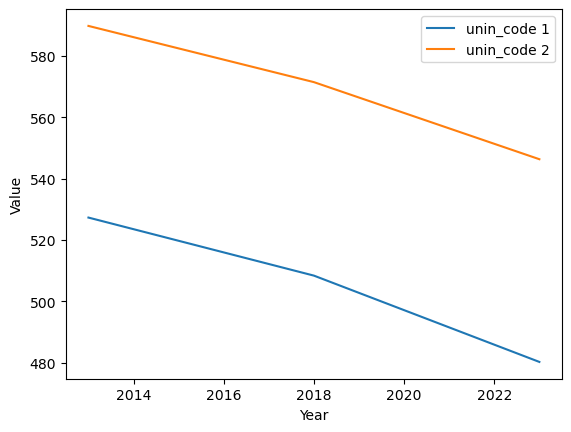

In [79]:
# Line Graph unions
for unin_code in merged_df["unin_code"].unique():
    subset = merged_df[merged_df['unin_code'] == unin_code]
    year_sum = subset.groupby('year')['value'].sum()
    plt.plot(year_sum.index, year_sum.values, label = f'unin_code {unin_code}')
    
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

A lot of my cleaning was done in the first milestone when I made the initial graphs. My data was really clean. I plan on not looking for clean data in the next class because I need more experience cleaning data.

# Question

**Based on only union membership and individuals represented by unions,what would be the best place to open a new location in three years?**

In [80]:
 # Notes to keep for this question:
  #- Unin_code = Code identifying union status
  #- state_name = Name of State
  #- fips_code = State Code
  #- Series_id = data for the Code identifying the specific series.
  #- value = % of people (union_code 1, 2, 3) by state
  
  #The series_id (LUU0202882000) can be broken out into:

#Code                   Value
#survey abbreviation=     LU
#seasonal (code)    =     U
#stype_code         =     0
#lfst_code          =     20
#seq_code           =    28820
#fips_code          =      00

# Notes: union code
unin_code

2

In [81]:
# Data set with State and union membership 
merged_df

,series_id,year,value,fips_code,state_name,unin_code
0,LUU0204899601,2013,10.7,1,Alabama,1
1,LUU0204899601,2018,9.2,1,Alabama,1
2,LUU0204899601,2023,7.5,1,Alabama,1
3,LUU0204899602,2013,23.1,2,Alaska,1
4,LUU0204899602,2018,18.5,2,Alaska,1
...,...,...,...,...,...,...
301,LUU0204899755,2018,8.6,55,Wisconsin,2
302,LUU0204899755,2023,8.4,55,Wisconsin,2
303,LUU0204899756,2013,6.4,56,Wyoming,2
304,LUU0204899756,2018,7.7,56,Wyoming,2


#### Linear Regression with Categorical Encoding

In [82]:
# Import packages

#Test and train
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
# Linear Regression
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# GridSearch to check all three
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
# Lasso
# Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import itertools

In [83]:
# Column names
merged_df.columns

Index(['series_id', 'year', 'value', 'fips_code', 'state_name', 'unin_code'], dtype='object')

In [84]:
# Look at year, state and union code
X = merged_df[['year', 'fips_code', 'unin_code']]

In [85]:
# Predict Y
y = merged_df['value']

In [86]:
# Make a train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

In [87]:
#Transform Data
# preprocessor transform columns
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical columns
        ('num', StandardScaler(), ['year']),  
        # Categorical columns
        ('cat', 'passthrough', ['fips_code', 'unin_code'])  
    ])

In [88]:
# K_means
kmeans = KMeans(random_state=42) 

In [89]:
models = {
    # Logistic Regession
    'Logistic_regression': {
        # Transform and process the model
        'model': Pipeline([
            ('preprocess', preprocessor),
            ('regress', LinearRegression())]),
        # Hyperparameters
        'params': {}
    },
    # Random forest
    'random_forest': {
        # Transform and process the model
        'model': Pipeline([
            ('preprocess', preprocessor),
            ('regress', RandomForestRegressor())]),
        # Hyperparameters
        'params':{'params': {
    'regress__n_estimators': [50, 100, 200],
    'regress__max_depth': [None, 10, 20],
    'regress__min_samples_split': [2, 5],
    'regress__min_samples_leaf': [1, 2],
    'regress__max_features': ['auto', 'sqrt'],
    'regress__bootstrap': [True, False]}} 
    },
}

In [90]:
ElasticNet??

In [91]:
# Try three different models
for name, info in models.items():
    print(f'Running Grid Search for {name}')
    grid_search = GridSearchCV(info['model'], param_grid=info['params'], cv=10, verbose=0)
    grid_search.fit(X_train, y_train)

Running Grid Search for liner_regression
Running Grid Search for random_forest
Running Grid Search for gradient_boosting


In [92]:
# Find the best estimator
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=2,
                                           min_samples_leaf=2,
                                           n_estimators=1000))])
{'regress__learning_rate': 0.5, 'regress__max_depth': 2, 'regress__min_samples_leaf': 2, 'regress__n_estimators': 1000}


In [93]:
# Predict y
y_pred = best_model.predict(X_test)

In [94]:
# Accuracy test (metrics)
mse = mean_squared_error(y_test, y_pred)
mas = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [95]:
# Print
print(f"Mean Absolute Error (MAE): {mas:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error (MAE): 0.935
Mean Squared Error (MSE): 1.512
Root Mean Squared Error (RMSE): 1.230
R^2 Score: 0.941



**Results**

**Test 1**
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress', GradientBoostingRegressor())])
{'regress__learning_rate': 0.1, 'regress__n_estimators': 100}

Mean Absolute Error (MAE): 1.757
Mean Squared Error (MSE): 4.757
Root Mean Squared Error (RMSE): 2.181
R^2 Score: 0.815

**Test 2**
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress',
                 GradientBoostingRegressor(learning_rate=0.3,
                                           n_estimators=500))])
{'regress__learning_rate': 0.3, 'regress__n_estimators': 500}

Mean Absolute Error (MAE): 1.757
Mean Squared Error (MSE): 1.890
Root Mean Squared Error (RMSE): 1.375
R^2 Score: 0.926
**Test 3**
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress', GradientBoostingRegressor(n_estimators=1000))])
{'regress__learning_rate': 0.1, 'regress__n_estimators': 1000}

Mean Absolute Error (MAE): 1.757
Mean Squared Error (MSE): 1.567
Root Mean Squared Error (RMSE): 1.252
R^2 Score: 0.939
**Test 4**
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress',
                 GradientBoostingRegressor(learning_rate=0.2, max_depth=2,
                                           min_samples_leaf=2,
                                           n_estimators=1000))])
{'regress__learning_rate': 0.2, 'regress__max_depth': 2, 'regress__min_samples_leaf': 2, 'regress__n_estimators': 1000}
Mean Absolute Error (MAE): 1.757
Mean Squared Error (MSE): 1.541
Root Mean Squared Error (RMSE): 1.242
R^2 Score: 0.940

**Test 5 - Best Test**

**Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=2,
                                           min_samples_leaf=2,
                                           n_estimators=1000))])
{'regress__learning_rate': 0.5, 'regress__max_depth': 2, 'regress__min_samples_leaf': 2, 'regress__n_estimators': 1000}
Mean Absolute Error (MAE): 0.935
Mean Squared Error (MSE): 1.512
Root Mean Squared Error (RMSE): 1.230
R^2 Score: 0.941**


**Test 6**
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress',
                 GradientBoostingRegressor(learning_rate=0.2, max_depth=2,
                                           min_samples_leaf=2,
                                           n_estimators=1000, subsample=0.9))])
{'regress__learning_rate': 0.2, 'regress__max_depth': 2, 'regress__min_samples_leaf': 2, 'regress__n_estimators': 1000, 'regress__subsample': 0.9}

Mean Absolute Error (MAE): 1.757
Mean Squared Error (MSE): 1.597
Root Mean Squared Error (RMSE): 1.264
R^2 Score: 0.938
**Test 7**
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress',
                 GradientBoostingRegressor(learning_rate=0.3, max_depth=2,
                                           min_samples_leaf=2,
                                           n_estimators=1000))])
{'regress__learning_rate': 0.3, 'regress__max_depth': 2, 'regress__min_samples_leaf': 2, 'regress__n_estimators': 1000}

Mean Absolute Error (MAE): 0.915
Mean Squared Error (MSE): 1.499
Root Mean Squared Error (RMSE): 1.224
R^2 Score: 0.942

**Test 8**
Running Grid Search for linear_regression
Running Grid Search for random_forest
Running Grid Search for gradient_boosting
Running Grid Search for lasso
Running Grid Search for elastic_net
Running Grid Search for svr
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('regress', LinearRegression())])
{'regress__C': 10, 'regress__degree': 4, 'regress__epsilon': 1, 'regress__kernel': 'poly'}
Mean Absolute Error (MAE): 4.178103049979377
Mean Squared Error (MSE): 25.5925273472311
Root Mean Squared Error (RMSE): 5.058905746031557
R^2 Score: 0.0024952896978454042

**Test 9**
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year']),
                                                 ('cat', 'passthrough',
                                                  ['fips_code',
                                                   'unin_code'])])),
                ('kmeans', KMeans(n_clusters=5, n_init=10, random_state=42)),
                ('regress',
                 GradientBoostingRegressor(learning_rate=0.3,
                                           min_samples_leaf=2,
                                           random_state=42))])
{'kmeans__n_clusters': 5, 'regress__learning_rate': 0.3, 'regress__max_depth': 3, 'regress__min_samples_leaf': 2, 'regress__n_estimators': 100}

Mean Absolute Error (MAE): 1.422
Mean Squared Error (MSE): 3.103
Root Mean Squared Error (RMSE): 1.761
R^2 Score: 0.879

In [96]:
# Check for overfitting
cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [97]:
# Check for overfitting or underfitting
cv = cross_validate(best_model, X, y, return_train_score=True)

In [98]:
# Extract and round the scores
train_scores = np.round(cv['train_score'], 3)
test_scores = np.round(cv['test_score'], 3)

In [99]:
# Calculate mean and standard deviation for both training and validation scores
train_mean = np.mean(train_scores)
train_std = np.std(train_scores)
test_mean = np.mean(test_scores)
test_std = np.std(test_scores)

In [100]:
# Print score
print(f"Train Scores: {train_scores}")
print(f"Test Scores: {test_scores}")
# Print mean score
print(f"Mean Train Score: {train_mean:.3f}")
print(f"Mean Test Score: {test_mean:.3f}")
#Print standard deviation
print(f"Standard Deviation of Train Scores: {train_std:.3f}")
print(f"Standard Deviation of Test Scores: {test_std:.3f}")

Train Scores: [0.989 0.988 0.989 0.99  0.989]
Test Scores: [0.932 0.973 0.969 0.96  0.963]
Mean Train Score: 0.989
Mean Test Score: 0.959
Standard Deviation of Train Scores: 0.001
Standard Deviation of Test Scores: 0.014


In [101]:
# List for 2028 data
fips_code_lt = dfs_fips['fips_code'].tolist()
unin_code_lt = [1,2]

In [102]:
# Make a combinations of all options
combinations = list(itertools.product(fips_code_lt, unin_code_lt))

In [103]:
# Make DataFrame
data_2028 = {
    'year': [2028] * len(combinations),
    'fips_code': [x[0] for x in combinations],
    'unin_code': [x[1] for x in combinations]}

In [104]:
# Make data frame
df_2028 = pd.DataFrame(data_2028)

In [105]:
df_2028

,year,fips_code,unin_code
0,2028,0,1
1,2028,0,2
2,2028,1,1
3,2028,1,2
4,2028,2,1
...,...,...,...
99,2028,54,2
100,2028,55,1
101,2028,55,2
102,2028,56,1


In [106]:
#Make the prediction
y_pred_2028 = best_model.predict(df_2028)

In [107]:
# Add to table
df_2028['Prediction'] = y_pred_2028

In [108]:
#year
year_28 = 2028
# Unique Code 2028
df_28_unique = df_2028['unin_code'].unique()

In [109]:
# map names
df_2028['state_name'] = df_2028['fips_code'].map(state_name)

I ended up using three different models: linear regression, random forest, and gradient boosting. I also tried Lasso and ElasticNet, but my model kept overfitting, so I removed them.<br>
**Linear Regression**<br>
Based on the scikit-learn algorithm cheat sheet, my model has some category data, but the year data could be numeric, so I tried linear regression. I was trying to predict 2028. Although better than random forest, it could have been a better model.<br>
**Random Forest**<br>
I tried the classifier Random Forest because I used the union variable, which is labeled data, to help predict the values. This was the worst model.<br>
**Gradient Boosting**<br>
Gradient boosting was the best model by far. It was chosen every time except when I tried using Lasso and Elasticnet, but as I mentioned before, it caused my test data to be overfitted. In my last test, I tried adding k-means with gradient boosting because I had less than 10K rows of data, and my categories were known. Although the test was good, it was better without it.

### Summary

**Model prediction:**<br>
GradientBoostingRegressor:
- learning_rate: 0.5<br>
- max_depth: 2 <br>
- min_samples_leaf: 2 <br>
- n_estimators: 1000 <br>

In [110]:
# Print score
print(f"Train Scores: {train_scores}")
print(f"Test Scores: {test_scores}")
# Print mean score
print(f"Mean Train Score: {train_mean:.3f}")
print(f"Mean Test Score: {test_mean:.3f}")
#Print standard deviation
print(f"Standard Deviation of Train Scores: {train_std:.3f}")
print(f"Standard Deviation of Test Scores: {test_std:.3f}")

Train Scores: [0.989 0.988 0.989 0.99  0.989]
Test Scores: [0.932 0.973 0.969 0.96  0.963]
Mean Train Score: 0.989
Mean Test Score: 0.959
Standard Deviation of Train Scores: 0.001
Standard Deviation of Test Scores: 0.014


In [111]:
# Print score
print(f"Differance Scores: {train_scores-test_scores}")
# Print mean score
print(f"Differance in Mean Score: {train_mean-test_mean:.3f}")
#Print standard deviation
print(f"Standard Deviation of Train Scores: {train_std-test_std:.3f}")

Differance Scores: [0.057 0.015 0.02  0.03  0.026]
Differance in Mean Score: 0.030
Standard Deviation of Train Scores: -0.014


I believe my model is a good predictor because there is a minimal deviation between the test and training data. The mean is high for the test and training data, which means my model fits the data very well. The standard deviation is also very low, meaning it is consistent and stable. The training and test scores are high, which means the data fits well. Although the training score is high, the test score is high, so it is not likely to be overfit.

#### Make a heat map

In [112]:
df_2028

,year,fips_code,unin_code,Prediction,state_name
0,2028,0,1,7.422533,U.S. Total
1,2028,0,2,8.549289,U.S. Total
2,2028,1,1,7.422533,Alabama
3,2028,1,2,8.549289,Alabama
4,2028,2,1,13.205583,Alaska
...,...,...,...,...,...
99,2028,54,2,9.640074,West Virginia
100,2028,55,1,7.202768,Wisconsin
101,2028,55,2,8.508881,Wisconsin
102,2028,56,1,5.423072,Wyoming


In [113]:
# Drop 0 from fips code
df_2028['fips_code'] = df_2028['fips_code'].drop(0)

In [114]:
# Remove territories from us_map
territories_to_remove = ['78', '66', '69', '60', '72']
us_map = us_map[~us_map['STATEFP'].isin(territories_to_remove)]

In [115]:
# Merge us_map with state_union_merge based on 'fips' and 'fips_code'
us_states_merged_28 = pd.merge(us_map, df_2028, left_on='NAME', right_on='state_name', how='left')

In [116]:
# Make a legder code
unicode_titles_map_28 = dict(zip(unin_code_28['unin_code'], unin_code_28['unin_text']))

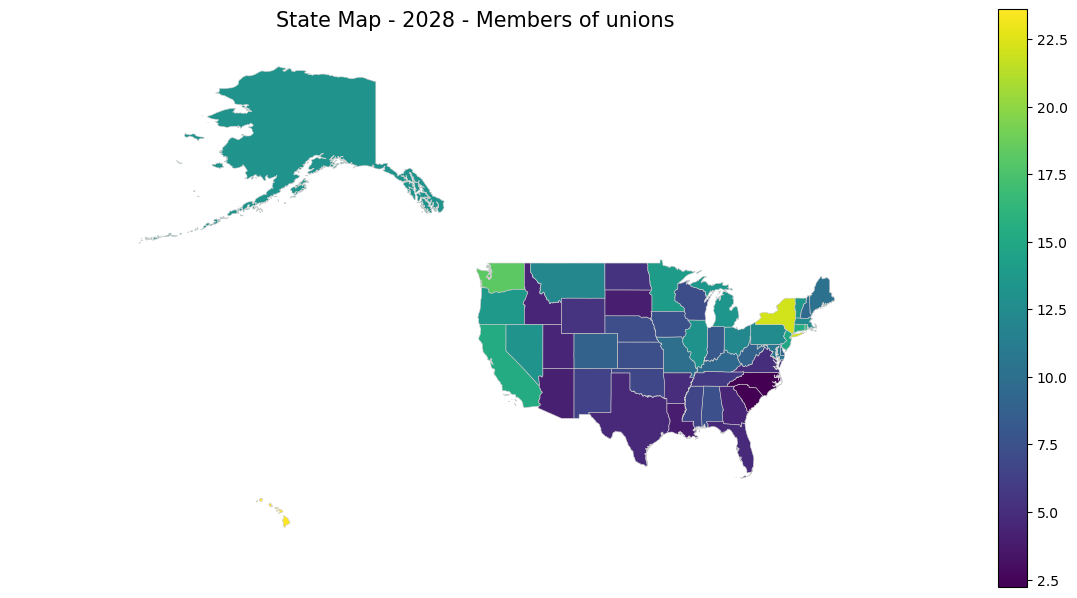

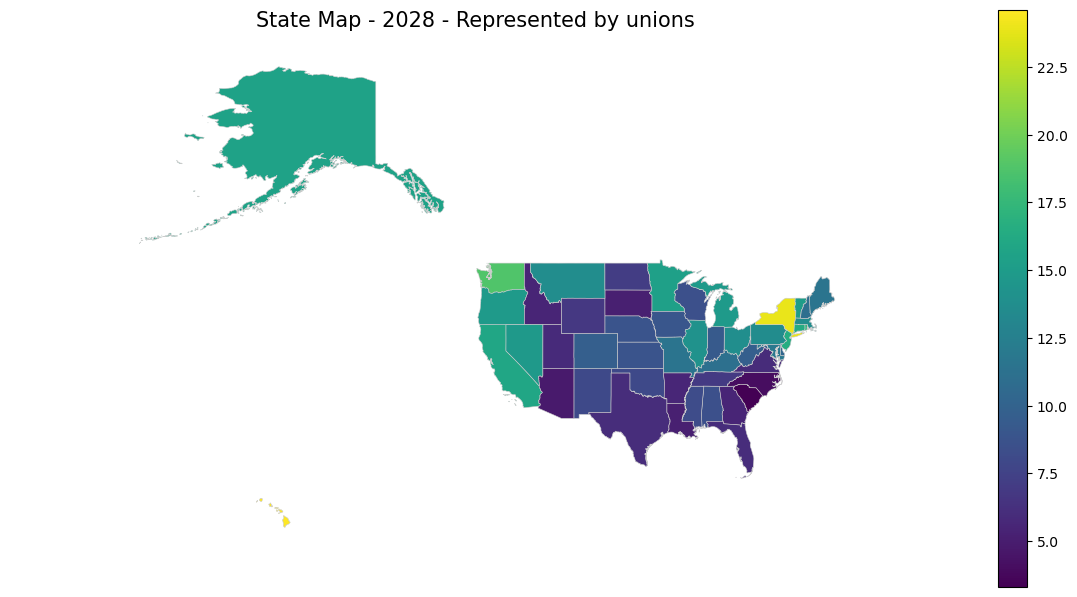

In [117]:
# for loop to plot people who are union and represented by a union on different maps
for code in us_states_merged_28['unin_code'].unique():
    # Filter the data for the current year and unique code
    year_data_28 = us_states_merged_28[(us_states_merged_28['year'] == 2028) & (us_states_merged_28['unin_code'] == code)]

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    year_data_28.plot(column='Prediction', cmap='viridis', linewidth=0.4, edgecolor='0.8', legend=True, legend_kwds={'shrink': 0.5}, ax=ax)
    
    # Set the title
    ax.set_title(f"State Map - {year_28} - {unicode_titles_map_28.get(code, 'Unknown Code')}", fontsize=15)
    
    # Set axis limits
    ax.set_xlim(-200, -50)
    ax.set_ylim(15, 75)
    
    # Remove axis
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    
    # Show the plot
    plt.show()